# Predicting Car Prices

The goal of this project is to predict a car's market price using its attributes and applying k-nearest neighbors (KNN) algorithm of machine learning (ML). The dataset can be downloaded from [this repository](https://archive.ics.uci.edu/ml/datasets/automobile), where we can also find all its details and the data description. The dataset contains information on various cars, including the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, etc.

## Initial Data Exploration

Since the dataset doesn't have a header row, we'll take the column names directly from the documentation:

In [241]:
import pandas as pd
import numpy as np

cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=cols)

# Displaying all the columns of the dataframe
pd.options.display.max_columns = 99
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [242]:
print('\033[1mNumber of rows:\033[0m\t\t', cars.shape[0],
      '\033[1m\nNumber of columns:\033[0m \t', cars.shape[1],
      '\n\033[1mNumber of missing values:\033[0m', cars.isnull().sum().sum())

Number of rows:		 205 
Number of columns: 	 26 
Number of missing values: 0


Observations:

- We don't have any NaN values in the dataframe. However, in the normalized-losses column, there are missing values represented by "?", which we'll have to fix later.
- There are 205 entries (cars) in the dataframe.
- From 26 columns, we need only numeric ones that can be used as features. Let's determine which columns are numeric from the documentation and keep only them in the dataframe:

In [243]:
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars[continuous_values_cols]
numeric_cars.shape

(205, 15)

## Data Cleaning

Earlier, we noticed the presence of missing values represented by "?" in the first 5 rows of the normalized-losses column. Probably, also some other columns contain such values. Let's replace the "?" values with NaN in the whole dataframe and double-check it for the presence of missing values again:

In [244]:
# Replacing "?" with NaN and rendering all the columns float
numeric_cars = numeric_cars.replace('?', np.nan)
numeric_cars.head(5)
numeric_cars = numeric_cars.astype('float')
numeric_cars.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

Now, the normalized-losses column contains most of all missing values (20%), while the others – from 0 to 2%. Dropping the whole column normalized-losses isn't a good idea: 80% of its data is valid and can be used for modeling. Since, price is the column we want to predict, let's remove any rows with missing price values.

In [245]:
numeric_cars = numeric_cars.dropna(subset=['price'])
numeric_cars.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

Next, we are going to replace all the missing values with the mean value of each corresponding column:

In [246]:
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

In [247]:
# Confirm that there's no more missing values!
numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

Next, we're going to normalize the values in all the numeric columns except for the target column price:

In [248]:
# Normalize all columnns to range from 0 to 1 except the target column.
price_col = numeric_cars['price']
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
numeric_cars['price'] = price_col
numeric_cars.head(3)

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.125,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.125,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.125,0.495327,0.346939,0.166667,0.263158,16500.0


Now, the data is clean and ready for further modeling. We're going to use test/train validation ML approach. We'll create both uni- and multivariate KNN models, estimate the error, and select the best model (with the lowest error).

## Test/Train Validation

### Creating Univariate Models

Let's start with creating simple univariate KNN models, one for each numeric column. As an evaluation metric, we'll use RMSE:

In [249]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

def knn_train_test(train_col, target_col, df):
    knn = KNeighborsRegressor()
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    # Fit a KNN model using default k value.
    knn.fit(train_df[[train_col]], train_df[target_col])
    
    # Make predictions using model.
    predicted_labels = knn.predict(test_df[[train_col]])

    # Calculate and return RMSE.
    mse = mean_squared_error(test_df[target_col], predicted_labels)
    rmse = np.sqrt(mse)
    return rmse

rmse_results = {}
train_cols = numeric_cars.columns.drop('price')

# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    rmse_results[col] = rmse_val

# Create a Series object from the dictionary so 
# we can easily view the results, sort, etc
rmse_results_series = pd.Series(rmse_results)
rmse_results_series.sort_values()

engine-size          3238.462830
horsepower           4037.037713
curb-weight          4401.118255
highway-mpg          4630.026799
width                4704.482590
city-mpg             4766.422505
length               5427.200961
wheel-base           5461.553998
compression-rate     6610.812153
bore                 6780.627785
normalized-losses    7330.197653
peak-rpm             7697.459696
stroke               8006.529545
height               8144.441043
dtype: float64

Using the default number of neighbors (k=5), we can conclude that the univariate model with engine-size variable performed the best, demonstrating the lowest error and, hence, the highest predictive capacity for the price. However, let's try to vary the values of k for each variable and observe the results:

In [250]:
def knn_train_test(train_col, target_col, df):
    np.random.seed(1)
        
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [1,3,5,7,9]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[[train_col]], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[[train_col]])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

# For each column (minus `price`), train a model, return RMSE value
# and add to the dictionary `rmse_results`.
train_cols = numeric_cars.columns.drop('price')
for col in train_cols:
    rmse_val = knn_train_test(col, 'price', numeric_cars)
    k_rmse_results[col] = rmse_val

k_rmse_results

{'bore': {1: 8602.58848450066,
  3: 6984.239489480916,
  5: 6780.627784685976,
  7: 6878.097965921532,
  9: 6866.808502038413},
 'city-mpg': {1: 5901.143574354764,
  3: 4646.746408727155,
  5: 4766.422505090134,
  7: 5232.523034167316,
  9: 5465.209492527533},
 'compression-rate': {1: 8087.205346523092,
  3: 7375.063685578359,
  5: 6610.812153159129,
  7: 6732.801282941515,
  9: 7024.485525463435},
 'curb-weight': {1: 5264.290230758878,
  3: 5022.318011757233,
  5: 4401.118254793124,
  7: 4330.608104418053,
  9: 4632.044474454401},
 'engine-size': {1: 3258.4861059962027,
  3: 2840.562805643501,
  5: 3238.4628296477176,
  7: 3563.086774256415,
  9: 3831.8244149840766},
 'height': {1: 8904.04645636071,
  3: 8277.609643045525,
  5: 8144.441042663747,
  7: 7679.598124393773,
  9: 7811.03606291223},
 'highway-mpg': {1: 6025.594966720739,
  3: 4617.305019788554,
  5: 4630.026798588056,
  7: 4796.061440186946,
  9: 5278.358056953987},
 'horsepower': {1: 4170.054848037801,
  3: 4020.8492630885

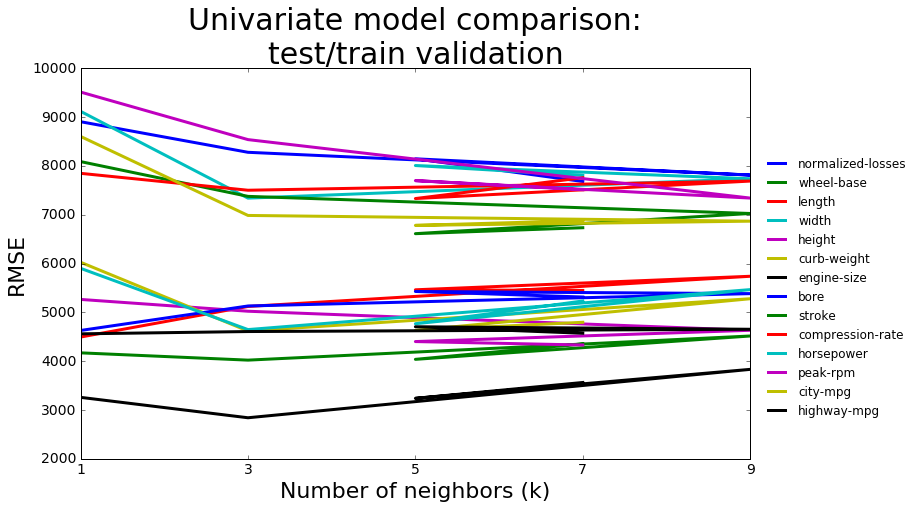

In [251]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,7))
for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())
    plt.title('Univariate model comparison:\ntest/train validation', fontsize=30)    
    plt.plot(x,y, linewidth=3)
    plt.xlabel('Number of neighbors (k)', fontsize=22)
    plt.ylabel('RMSE', fontsize=22)
    plt.xticks([1,3,5,7,9], fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(1,9)
    plt.legend(train_cols, frameon=False, bbox_to_anchor=(1.25, 0.8), fontsize=12)
plt.show()

### Creating Multivariate Models

Next, let's create some multivariate models. First, we're going to try different combinations of the best features (with the lowest average RMSE) from the previous step to train and test a multivariate KNN model using the default k value (k=5): 2, 3, 4, and 5 best features:

In [252]:
# Compute average RMSE across different `k` values for each feature.
feature_avg_rmse = {}
for k,v in k_rmse_results.items():
    avg_rmse = np.mean(list(v.values()))
    feature_avg_rmse[k] = avg_rmse
series_avg_rmse = pd.Series(feature_avg_rmse)
sorted_series_avg_rmse = series_avg_rmse.sort_values()
print(sorted_series_avg_rmse)

sorted_features = sorted_series_avg_rmse.index

engine-size          3346.484586
horsepower           4219.377860
width                4618.910560
curb-weight          4730.075815
highway-mpg          5069.469256
length               5176.394904
city-mpg             5202.409003
wheel-base           5252.392462
compression-rate     7166.073599
bore                 7222.472445
normalized-losses    7624.407151
stroke               8000.240467
peak-rpm             8119.365233
height               8163.346266
dtype: float64


The 5 best features are: engine-size, horsepower, width, curb-weight, highway-mpg. Hence, we have to consider the following combinations:

- engine-size, horsepower
- engine-size, horsepower, width
- engine-size, horsepower, width, curb-weight
- engine-size, horsepower, width, curb-weight, highway-mpg

In [253]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [5]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for nr_best_feats in range(2,6):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        numeric_cars
    )

k_rmse_results

{'2 best features': {5: 2949.8817277180374},
 '3 best features': {5: 3580.7376651928435},
 '4 best features': {5: 3487.340917327035},
 '5 best features': {5: 3410.2170133901805}}

The models in the order of the lowest RMSE from the previous step are:

- With 2 best features (engine-size, horsepower) and RMSE= 2949.
- With 5 best features (engine-size, horsepower, width, curb-weight, highway-mpg) and RMSE=3410.
- With 4 best features (engine-size, horsepower, width, curb-weight) and RMSE=3487.
- With 5 best features (engine-size, horsepower, width, curb-weight, highway-mpg) and RMSE=3580.

Let's tune the hyperparameter k for each of these models and observe the results:

In [254]:
def knn_train_test(train_cols, target_col, df):
    np.random.seed(1)
    
    # Randomize order of rows in data frame.
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)

    # Divide number of rows in half and round.
    last_train_row = int(len(rand_df) / 2)
    
    # Select the first half and set as training set.
    # Select the second half and set as test set.
    train_df = rand_df.iloc[0:last_train_row]
    test_df = rand_df.iloc[last_train_row:]
    
    k_values = [i for i in range(1, 25)]
    k_rmses = {}
    
    for k in k_values:
        # Fit model using k nearest neighbors.
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(train_df[train_cols], train_df[target_col])

        # Make predictions using model.
        predicted_labels = knn.predict(test_df[train_cols])

        # Calculate and return RMSE.
        mse = mean_squared_error(test_df[target_col], predicted_labels)
        rmse = np.sqrt(mse)
        
        k_rmses[k] = rmse
    return k_rmses

k_rmse_results = {}

for nr_best_feats in range(2,6):
    k_rmse_results['{} best features'.format(nr_best_feats)] = knn_train_test(
        sorted_features[:nr_best_feats],
        'price',
        numeric_cars
    )

k_rmse_results

{'2 best features': {1: 2783.6204237227344,
  2: 2657.7963807419765,
  3: 2792.586573031673,
  4: 2891.5329686923255,
  5: 2949.8817277180374,
  6: 3096.402601694776,
  7: 3164.681969020496,
  8: 3413.228359192009,
  9: 3748.6716603306486,
  10: 4080.7125057341937,
  11: 4215.6372280600335,
  12: 4275.421524277872,
  13: 4373.901683035496,
  14: 4424.285137239815,
  15: 4539.505493095937,
  16: 4667.307671446768,
  17: 4729.605305844226,
  18: 4790.556632159094,
  19: 4824.3866193292615,
  20: 4840.850914693829,
  21: 4837.429062000271,
  22: 4831.16988267597,
  23: 4861.679492959275,
  24: 4903.346008862579},
 '3 best features': {1: 3399.8148100410203,
  2: 3497.191103423058,
  3: 3333.6966577570593,
  4: 3355.8842294742026,
  5: 3580.7376651928435,
  6: 3732.943016673517,
  7: 3639.9439408462786,
  8: 3747.4209132113137,
  9: 3986.593913133887,
  10: 4005.354888715163,
  11: 4121.687230061635,
  12: 4255.700651624227,
  13: 4328.476829895253,
  14: 4332.216494947217,
  15: 4388.22571

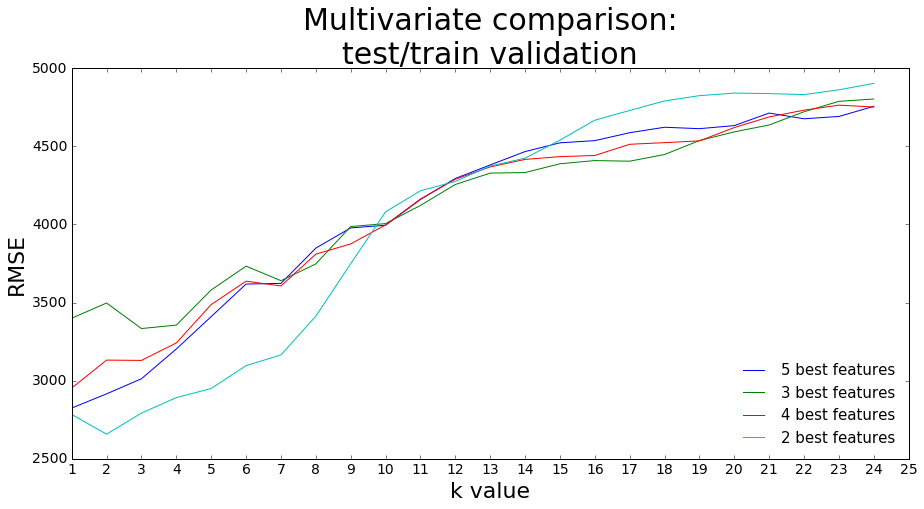

In [255]:
plt.figure(figsize=(15,7))
for k,v in k_rmse_results.items():
    x = list(v.keys())
    y = list(v.values())  
    plt.plot(x,y, label="{}".format(k))
plt.title('Multivariate comparison:\ntest/train validation', fontsize=30)    
plt.xlabel('k value', fontsize=22)
plt.ylabel('RMSE', fontsize=22)
plt.xlim(1,25)
plt.xticks(list(range(1,26)), fontsize=14)
plt.yticks(fontsize=14)
plt.legend(frameon=False, loc=4, bbox_to_anchor=None, fontsize=15)

Since our goal is to select the model with the smallest error and, hence, the highest predictive capacity for the car price, let's review our best results so far:

Univariate models:
- Default k=5: engine-size (RMSE=3238).
- Optimal k=1: engine-size (RMSE=2840).

Multivariate models:
- Default k=5: engine-size and horsepower (RMSE=2949).
- Optimal k=2 engine-size and horsepower (RMSE=2657).

In general, the difference between all the RMSE values above isn't considerable. The lowest RMSE is related to the multivariate model with engine-size, horsepower and k=2. However, In practice, considering too few neighbors (i.e. too small values of k) implies a high impact of noise on the result. Instead, considering too many neighbors results in involving irrelevant neighbors from other clusters (and indeed, for higher values of k, the error is constantly increasing).

Hence, a safer choice is the multivariate model with engine-size & horsepower and RMSE=2949.

## Conclusion

In this project, we used the KNN algorithm, in particular test/train validation to create uni- and multivariate ML models for predicting a car's market price based on its attributes. We tried different features and their combinations, different nearest neighbors.

As a result, the best predictive capacity for the car price was obtained for a multivariate model with 2 features (engine-size, horsepower) created by applying test/train validation.

This model has demonstrated the lowest error, has engine-size as one of the features. Hence, the engine size is one of the most influencing factors on the car price.